# Importing the libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

# Data Analysis

Use Kaggle’s MasterCard stock dataset from May-25-2006 to Oct-11-2021: https://www.kaggle.com/datasets/kalilurrahman/mastercard-stock-data-latest-and-updated

In [30]:
dataset = pd.read_csv(
    "Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)

print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [31]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


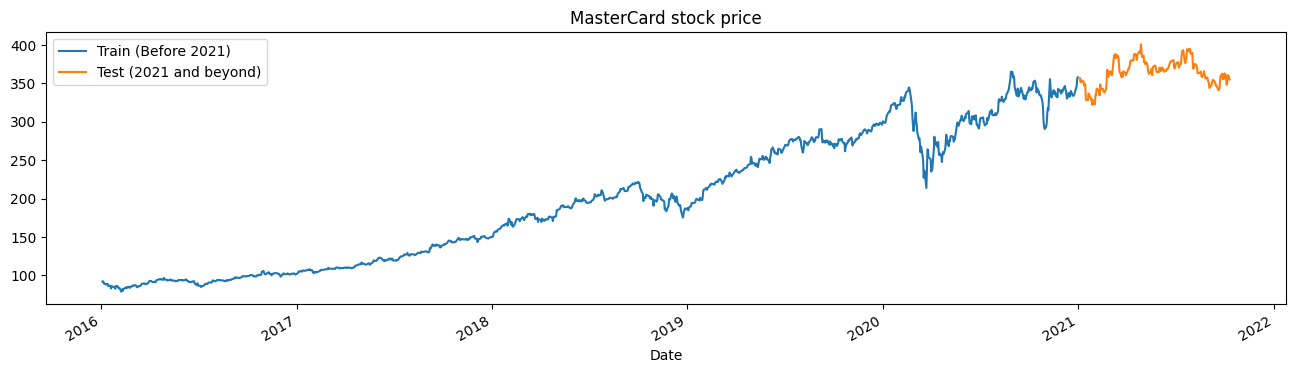

In [32]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

# Data Preprocessing

In [33]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [34]:
# Try using StandardScaler or any other scalar function
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).

For example, if the sequence is [1,2,3,4,5,6,7,8,9,10,11,12] and the n_step is three, then it will convert the sequence into three input timestamps and one output as shown below:

X	y
1,2,3	4
2,3,4	5
3,4,5	6
4,5,6	7
…	…

In [35]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 45
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

In [36]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [50]:
# Adjusting LSTM model parameters
model_lstm = Sequential()
model_lstm.add(GRU(units=64, activation='relu', return_sequences=True, input_shape=(n_steps, features)))
model_lstm.add(GRU(units=32, activation='relu'))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                         │ (None, 45, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.1482
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0089
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 6.6848e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 4.2511e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.0933e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.9970e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.7505e-04
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.8082e-04
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 3.0067e-04
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 3.2515e-04
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 3.0352e-04
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 2.8525e-04
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 2.8505e-04
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.3854e-04
Epoch 15/

# Results

In [52]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step


In [53]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


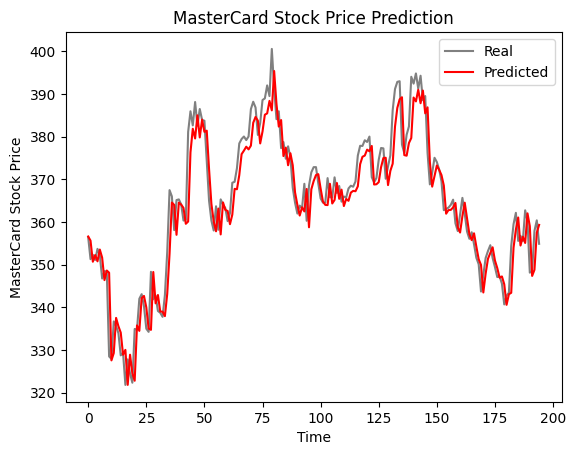

In [54]:
plot_predictions(test_set,predicted_stock_price)

You have to train model to produce RMSE <= 6.35.


<=0.35 0.35 3.35 6.35 9.35 12.35
A      B+   B    C+   C    D+    D

In [55]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 5.38.


In [45]:
# Adjusting GRU model parameters without Dropout
model_gru = Sequential()
model_gru.add(GRU(units=64, activation='relu', return_sequences=True, input_shape=(n_steps, features)))
model_gru.add(GRU(units=32, activation='relu'))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mse')

model_gru.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                          │ (None, 45, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.1058
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0020
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 3.8953e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 4.1915e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.1488e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 3.3547e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 2.8308e-04
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.7313e-04
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.6553e-04
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.8813e-04
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.8663e-04
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 2.1081e-04
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 2.3767e-04
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.2956e-04
Epoch

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


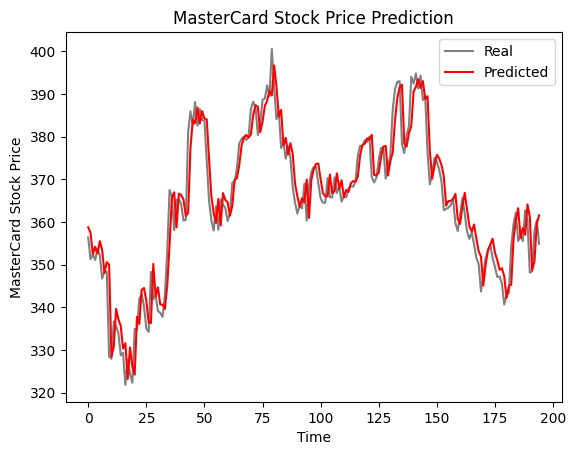

In [47]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

<=2.00 2.00 5.00 8.00 11.00 14.00
A      B+   B    C+   C     D+    D

In [48]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.32.


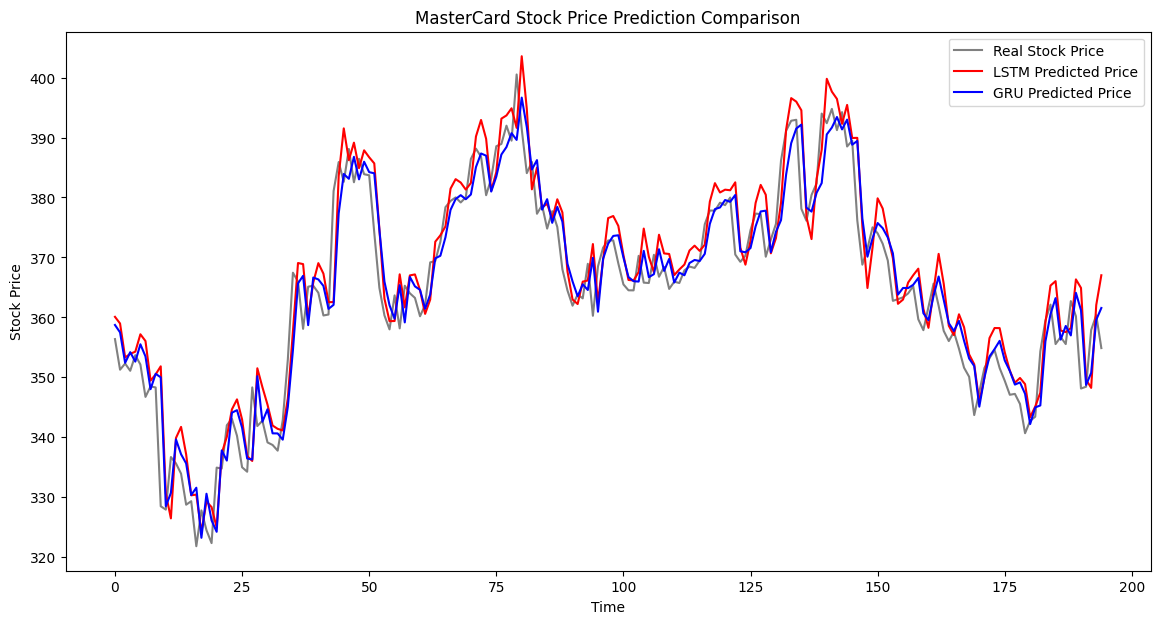

In [49]:
# Plotting comparison of LSTM and GRU predictions
def plot_comparison(test, lstm_pred, gru_pred):
    plt.figure(figsize=(14, 7))
    plt.plot(test, color='gray', label='Real Stock Price')
    plt.plot(lstm_pred, color='red', label='LSTM Predicted Price')
    plt.plot(gru_pred, color='blue', label='GRU Predicted Price')
    plt.title('MasterCard Stock Price Prediction Comparison')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

plot_comparison(test_set, predicted_stock_price, GRU_predicted_stock_price)
